# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import datetime
import os
import glob

In [2]:
#Importing alternatives to scipy.misc.imread and imresize
import PIL
from PIL import Image
from imageio import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [4]:
#tf.set_random_seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
os.getcwd()

'C:\\Users\\niraj\\Upgrad_ML\\29 Gesture Recognition Case Study'

In [6]:
train_doc = np.random.permutation(open(os.getcwd() + '/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open(os.getcwd() + '/Project_data/val.csv').readlines())
batch_size = 64

### Viewing an image

In [7]:
path = os.getcwd() + "/Project_data/train/*"
# for name in glob.glob(path)
#     sub_folders.append(name)
sub_folders = [name + '/*.png' for name in glob.glob(path)]

In [8]:
#Setting image dimensions for resizing
img_width = 120
img_height = 160

#### Checking if our cropping and resizing works

(360, 360, 3)


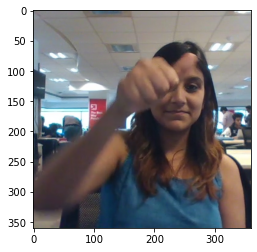

In [9]:
image = imread(list(glob.glob(sub_folders[100]))[0])
print(image.shape)
plt.imshow(image)

#We can also open the image directly by using:
#PIL.Image.open(list(glob.glob(sub_folders[75]))[0])

In [10]:
image_cropped = image[45:316, :]
image_resized = resize(image_cropped, (img_width, img_height, 3))
image_resized_cropped = image_resized[5:115, :, :]
image_resized_cropped.shape

(110, 160, 3)

(110, 160, 3)


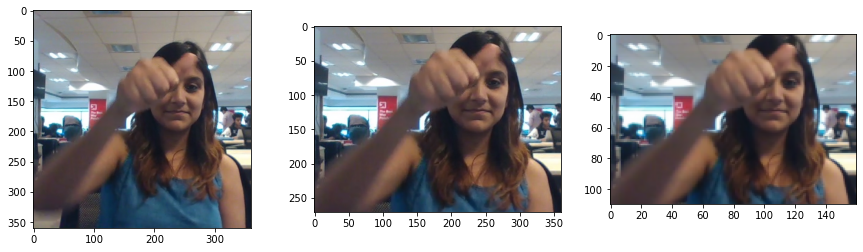

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
axes[0].imshow(image)
axes[1].imshow(image_cropped)
axes[2].imshow(image_resized_cropped)
print(image_resized_cropped.shape)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [12]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [1, 4, 7, 10, 12, 14, 16, 18, 20, 23, 26, 29]    #create a list of image numbers you want to use for a particular video
    
    x = len(img_idx)
    y = 110    #Since we're cropping 10px from the sides
    z = 160
    
    while True:
        t = np.random.permutation(folder_list)
        
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        
        for batch in range(num_batches): # we iterate over the number of batches
            
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    #Cropping the upper and lower ends of the larger images
                    if image.shape[0] == 360:
                        image_cropped = image[45:316, :]      #This crops the 360x360 images to 360x270. This is the same aspect ratio as 160x120    
                    else:
                        image_cropped = image
                    
                    #Resizing all images to a standard size
                    image_resized = resize(image_cropped, (img_width, img_height, 3))
                    #Note: the skimage.transform resize function appears to prefer its output shape in (rows, cols[, dim])
                    
                    #Now cropping the left and right sides by 10px (totally) to get image size of 160x110
                    image_resized_cropped = image_resized[5:115, :, :]
                    
                    batch_data[folder,idx,:,:,0] = (image_resized_cropped[:, :, 0])/255         #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized_cropped[:, :, 1])/255         #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized_cropped[:, :, 2])/255         #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what yield does

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)/batch_size != 0):
            
            batch_size_rem = len(t) % batch_size
            
            batch_data = np.zeros((batch_size_rem, x, y, z, 3)) 
            batch_labels = np.zeros((batch_size_rem, 5))
            
            for folder in range(batch_size_rem): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #Cropping the upper and lower ends of the larger images
                    if image.shape[0] == 360:
                         image_cropped = image[45:316, :]      #This crops the 360x360 images to 360x270. This is the same aspect ratio as 160x120    
                    else:
                        image_cropped = image
                    
                    #Resizing all images to a standard size
                    image_resized = resize(image_cropped, (img_width, img_height, 3))
                    #Note: the skimage.transform resize function appears to prefer its output shape in (rows, cols[, dim])
                    
                    #Now cropping the left and right sides by 10px (totally) to get final image size of 160x110
                    image_resized_cropped = image_resized[5:115, :, :]
                    
                    batch_data[folder,idx,:,:,0] = (image_resized_cropped[:, :, 0])/255         #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized_cropped[:, :, 1])/255         #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized_cropped[:, :, 2])/255         #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            
            yield batch_data, batch_labels 


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [13]:
curr_dt_time = datetime.datetime.now()
train_path = os.getcwd() + '/Project_data/train'
val_path = os.getcwd() + '/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [14]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

from keras.layers import Input
from keras.layers import LeakyReLU

In [15]:
print(tf.__version__)
print(keras.__version__)

2.1.0
2.3.1


In [16]:
seq_length = len([1, 4, 7, 10, 12, 14, 16, 18, 20, 23, 26, 29])
img_width_final = 160
img_height_final = 110
num_classes = 5

#### Creating a function to plot model accuracies

In [17]:
def plot(history, model_num):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['Training Loss','Validation Loss'])
    axes[0].set_title("Loss")
    
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['Training acc','Validation acc'])
    axes[1].set_title("Accuracy")
    
#     #To set the same x and y-axis labels for both subplots:
#     #Also see: https://matplotlib.org/3.1.1/gallery/subplots_axes_and_figures/subplots_demo.html
#     for ax in axes.flat:
#         ax.set(xlabel='Epoch', ylabel='Accuracy')
    
    plt.suptitle("Model " + model_num, fontsize = 16)

In [18]:
from keras.applications import MobileNetV2

In [19]:
mobilenet_transfer = MobileNetV2(
    include_top=False,
    weights="imagenet"
)

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


### 13. Using MobileNetV2 and GRU, small number of parameters, and reduced dropouts

In [20]:
#Defining the hyperparameters that are specific to this model

dense_neurons = 8       #Same as previous
dropout = 0.04         #Decreased from 0.075
gru_cells = 8           #Same as previous


model_13 = Sequential()

model_13.add(TimeDistributed(mobilenet_transfer, input_shape=(seq_length, img_height_final, img_width_final, 3)))

#Making the MobileNet parameters trainable:
for layer in model_13.layers:
            layer.trainable = True

model_13.add(TimeDistributed(BatchNormalization()))
model_13.add(TimeDistributed(MaxPooling2D((2, 2))))     #Finds the max value in a (2,2) grid
model_13.add(TimeDistributed(Flatten()))

model_13.add(GRU(gru_cells))
model_13.add(Dropout(dropout))

model_13.add(Dense(dense_neurons, activation=None))
model_13.add(LeakyReLU(alpha=0.2))                     #alpha is the negative slope coefficient
model_13.add(Dropout(dropout))

model_13.add(Dense(num_classes, activation='softmax'))

#### Compiling the model

In [21]:
optimiser = optimizers.SGD(lr=0.001, nesterov=True)
model_13.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_13.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 12, 3, 5, 1280)    2257984   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 12, 3, 5, 1280)    5120      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 12, 1, 2, 1280)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 12, 2560)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 61656     
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                

#### Instantiating the generators again, to avoid StopIteration errors; also specifying the batch size for this model

In [22]:
batch_size = 8

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

#### Saving the models created after each epoch

In [23]:
model_name = 'model_13' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.3, verbose=1, patience=2)   #v
ES = EarlyStopping(monitor='val_loss', patience=8, verbose=1, mode='auto')
callbacks_list = [checkpoint, LR]

#### Calculating the steps_per_epoch and validation_steps and setting the number of epochs for this model

In [24]:
num_epochs = 50

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [25]:
history_13 = model_13.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Epoch 1/50
 C:\Users\niraj\Upgrad_ML\29 Gesture Recognition Case Study/Project_data/val ; batch size = 8
Source path =  C:\Users\niraj\Upgrad_ML\29 Gesture Recognition Case Study/Project_data/train ; batch size = 8
83/83 [==============================] - 236s 3s/step - loss: 1.5503 - categorical_accuracy: 0.2956 - val_loss: 1.5872 - val_categorical_accuracy: 0.2700

Epoch 00001: saving model to model_13_2021-03-0114_39_59.572868/model-00001-1.55060-0.29563-1.58724-0.27000.h5
Epoch 2/50
83/83 [==============================] - 203s 2s/step - loss: 1.3766 - categorical_accuracy: 0.3786 - val_loss: 1.3641 - val_categorical_accuracy: 0.3200

Epoch 00002: saving model to model_13_2021-03-0114_39_59.572868/model-00002-1.37652-0.37858-1.36407-0.32000.h5
Epoch 3/50
83/83 [==============================] - 204s 2s/step - loss: 1.2246 - categorical_accuracy: 0.5038 - val_loss: 1.5874 - val_categorical_accuracy: 0.3600

Epoch 00003: saving model to model_13_2021-03-0114_39_59.57286


Epoch 00027: ReduceLROnPlateau reducing learning rate to 6.561000276406048e-08.
Epoch 28/50
83/83 [==============================] - 204s 2s/step - loss: 0.7598 - categorical_accuracy: 0.8431 - val_loss: 1.0479 - val_categorical_accuracy: 0.6700

Epoch 00028: saving model to model_13_2021-03-0114_39_59.572868/model-00028-0.75971-0.84314-1.04793-0.67000.h5
Epoch 29/50
83/83 [==============================] - 204s 2s/step - loss: 0.7715 - categorical_accuracy: 0.8235 - val_loss: 1.1800 - val_categorical_accuracy: 0.6700

Epoch 00029: saving model to model_13_2021-03-0114_39_59.572868/model-00029-0.77157-0.82353-1.18003-0.67000.h5

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.9683000829218145e-08.
Epoch 30/50
83/83 [==============================] - 104s 1s/step - loss: 0.7691 - categorical_accuracy: 0.8190 - val_loss: 1.2121 - val_categorical_accuracy: 0.6800

Epoch 00030: saving model to model_13_2021-03-0114_39_59.572868/model-00030-0.76930-0.81900-1.21206-0.68000.h5
Epo

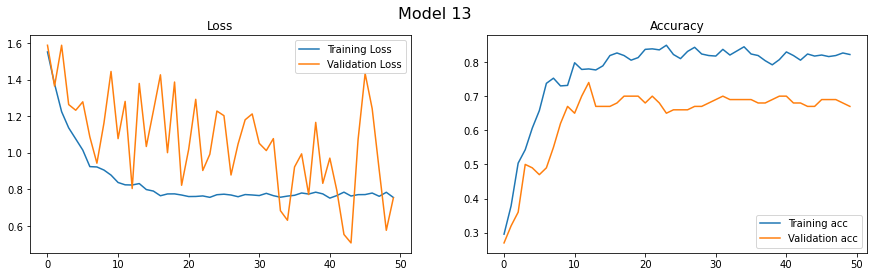

In [27]:
plot(history_13, '13')

This model is overfitting, as the gap between and training and validation accuracy is quite large. Also, the validation loss has not stabilized.

### 14. Previous model with momentum=0.9 for optimizer

In [28]:
#Defining the hyperparameters that are specific to this model

dense_neurons = 8       #Same as previous
dropout = 0.04         #Decreased from 0.075
gru_cells = 8           #Same as previous


model_14 = Sequential()

model_14.add(TimeDistributed(mobilenet_transfer, input_shape=(seq_length, img_height_final, img_width_final, 3)))

#Making the MobileNet parameters trainable:
for layer in model_14.layers:
            layer.trainable = True

model_14.add(TimeDistributed(BatchNormalization()))
model_14.add(TimeDistributed(MaxPooling2D((2, 2))))     #Finds the max value in a (2,2) grid
model_14.add(TimeDistributed(Flatten()))

model_14.add(GRU(gru_cells))
model_14.add(Dropout(dropout))

model_14.add(Dense(dense_neurons, activation=None))
model_14.add(LeakyReLU(alpha=0.2))                     #alpha is the negative slope coefficient
model_14.add(Dropout(dropout))

model_14.add(Dense(num_classes, activation='softmax'))

#### Compiling the model

In [37]:
optimiser = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
model_14.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_14.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 12, 3, 5, 1280)    2257984   
_________________________________________________________________
time_distributed_6 (TimeDist (None, 12, 3, 5, 1280)    5120      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 12, 1, 2, 1280)    0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 12, 2560)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 8)                 61656     
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                

#### Instantiating the generators again, to avoid StopIteration errors; also specifying the batch size for this model

In [38]:
batch_size = 8

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

#### Saving the models created after each epoch

In [39]:
model_name = 'model_14' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.3, verbose=1, patience=2)   #v
ES = EarlyStopping(monitor='val_categorical_accuracy', patience=15, verbose=1, mode='auto')
callbacks_list = [checkpoint, ES, LR]

#### Calculating the steps_per_epoch and validation_steps and setting the number of epochs for this model

In [40]:
num_epochs = 50

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [41]:
history_14 = model_14.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  C:\Users\niraj\Upgrad_ML\29 Gesture Recognition Case Study/Project_data/val ; batch size = 8
Epoch 1/50
Source path =  C:\Users\niraj\Upgrad_ML\29 Gesture Recognition Case Study/Project_data/train ; batch size = 8
83/83 [==============================] - 221s 3s/step - loss: 0.6184 - categorical_accuracy: 0.8763 - val_loss: 1.2080 - val_categorical_accuracy: 0.7000

Epoch 00001: saving model to model_14_2021-03-0114_39_59.572868/model-00001-0.61826-0.87632-1.20801-0.70000.h5
Epoch 2/50
83/83 [==============================] - 205s 2s/step - loss: 0.5499 - categorical_accuracy: 0.8763 - val_loss: 0.6910 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_14_2021-03-0114_39_59.572868/model-00002-0.54993-0.87632-0.69099-0.57000.h5
Epoch 3/50
83/83 [==============================] - 205s 2s/step - loss: 0.4647 - categorical_accuracy: 0.8884 - val_loss: 1.6311 - val_categorical_accuracy: 0.6400

Epoch 00003: saving model to model_14_2021-03-0114_39_59.57286


Epoch 00027: ReduceLROnPlateau reducing learning rate to 2.1870000637136398e-07.
Epoch 28/50
83/83 [==============================] - 205s 2s/step - loss: 0.1121 - categorical_accuracy: 0.9819 - val_loss: 0.0580 - val_categorical_accuracy: 0.9700

Epoch 00028: saving model to model_14_2021-03-0114_39_59.572868/model-00028-0.11213-0.98190-0.05802-0.97000.h5
Epoch 29/50
83/83 [==============================] - 204s 2s/step - loss: 0.1167 - categorical_accuracy: 0.9834 - val_loss: 0.0791 - val_categorical_accuracy: 0.9700

Epoch 00029: saving model to model_14_2021-03-0114_39_59.572868/model-00029-0.11676-0.98341-0.07914-0.97000.h5

Epoch 00029: ReduceLROnPlateau reducing learning rate to 6.561000276406048e-08.
Epoch 30/50
83/83 [==============================] - 204s 2s/step - loss: 0.1144 - categorical_accuracy: 0.9819 - val_loss: 0.0545 - val_categorical_accuracy: 0.9700

Epoch 00030: saving model to model_14_2021-03-0114_39_59.572868/model-00030-0.11436-0.98190-0.05449-0.97000.h5
Epo

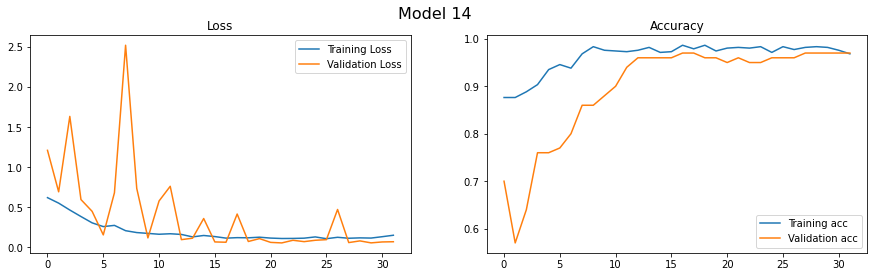

In [42]:
plot(history_14, '14')

This model has very good performance on both the train and validation sets.